In [95]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf

yf.pdr_override()
import pandas as pd

ticker_list=["AAPL",  "AMZN", "TSLA", "GOOGL", "GOOG"]
today = date.today()
# We can get data by our choice by giving days bracket
start_date= "2020-11-30"
# end_date="2020-11-30"

files=[]
def getData(ticker):
    data = pdr.get_data_yahoo(ticker, start=start_date, end=today)
    # dataname= ticker+"_"+str(today)
    files.append((data,ticker))
    
for tik in ticker_list:
    getData(tik)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [96]:
closing_price = []
for stock_df in files:
    closing_price.append(stock_df[0].Close)

stocks = pd.concat(closing_price, axis = 1)
stocks.columns = ticker_list
stocks

,AAPL,AMZN,TSLA,GOOGL,GOOG
Date,,,,,
2020-11-30,119.050003,3168.040039,567.599976,1754.400024,1760.739990
2020-12-01,122.720001,3220.080078,584.760010,1795.359985,1798.099976
2020-12-02,123.080002,3203.530029,568.820007,1824.969971,1827.949951
2020-12-03,122.940002,3186.729980,593.380005,1821.839966,1826.770020
2020-12-04,122.250000,3162.580078,599.039978,1823.760010,1827.989990
...,...,...,...,...,...
2022-04-06,171.830002,3175.120117,1045.760010,2730.959961,2743.520020
2022-04-07,172.139999,3155.689941,1057.260010,2717.770020,2729.300049
2022-04-08,170.089996,3089.209961,1025.489990,2665.750000,2680.209961


In [105]:
stocks.pct_change(1)

,AAPL,AMZN,TSLA,GOOGL,GOOG
Date,,,,,
2020-11-30,NaN,NaN,NaN,NaN,NaN
2020-12-01,0.030827,0.016427,0.030233,0.023347,0.021218
2020-12-02,0.002934,-0.005140,-0.027259,0.016493,0.016601
2020-12-03,-0.001137,-0.005244,0.043177,-0.001715,-0.000645
2020-12-04,-0.005613,-0.007578,0.009539,0.001054,0.000668
...,...,...,...,...,...
2022-04-06,-0.018451,-0.032300,-0.041695,-0.028757,-0.027555
2022-04-07,0.001804,-0.006120,0.010997,-0.004830,-0.005183
2022-04-08,-0.011909,-0.021067,-0.030049,-0.019141,-0.017986


In [106]:
import numpy as np

log_return = np.log(stocks/stocks.shift(1))
log_return.head()

,AAPL,AMZN,TSLA,GOOGL,GOOG
Date,,,,,
2020-11-30,NaN,NaN,NaN,NaN,NaN
2020-12-01,1.030827,1.016427,1.030233,1.023347,1.021218
2020-12-02,1.002934,0.994860,0.972741,1.016493,1.016601
2020-12-03,0.998863,0.994756,1.043177,0.998285,0.999355
2020-12-04,0.994387,0.992422,1.009539,1.001054,1.000668


In [99]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
    sr = ret/vol 
    return np.array([ret,vol,sr])


# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)[2] * -1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

# create constraint variable
cons = ({'type':'eq','fun':check_sum})

# create weight boundaries
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1))


# initial guess
init_guess = [0.2, 0.2, 0.2, 0.2, 0.2]

opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [100]:
opt_results

     fun: -1.1536179881807929
     jac: array([ 4.25741076e-04,  1.07495680e+00,  3.35693359e-04,  1.20179802e-02,
       -2.68355012e-04])
 message: 'Optimization terminated successfully'
    nfev: 60
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([3.10994985e-01, 0.00000000e+00, 8.69194127e-02, 1.99493200e-17,
       6.02085602e-01])

In [89]:
get_ret_vol_sr(opt_results.x)

array([0.29481878, 0.26319724, 1.12014389])

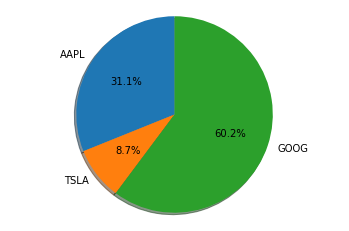

In [104]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
updated_ticker_list = ['AAPL', 'TSLA', 'GOOG']
opt_weights = [31.099498485409573, 8.691941268853846 , 60.20856024573664]
explode = (0, 0, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(opt_weights, explode=explode, labels=updated_ticker_list, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(r'C:\Users\saina\OneDrive - City University of Hong Kong\Desktop\cityu\Cityu Year 4\FYP\code\frontend_react\public\images\opt_portfolio.jpg')

plt.show()